Start of COlab

In [ ]:
!wget -O dtrb.zip -q https://github.com/lohzhunyewcs/deep-text-recognition-benchmark/archive/refs/heads/transformer.zip

In [ ]:
!unzip -q dtrb.zip

In [ ]:
import sys
sys.path.append('/content/deep-text-recognition-benchmark-transformer')

In [ ]:
!mkdir deep-text-recognition-benchmark-master/data

In [ ]:
!wget -O data_lmdb_release.zip https://www.dropbox.com/sh/i39abvnefllx2si/AABX4yjNn2iLeKZh1OAwJUffa/data_lmdb_release.zip?dl=1

In [ ]:
!!mkdir data_lmdb_release

In [ ]:
!unzip data_lmdb_release.zip "data_lmdb_release/training/MJ/MJ_train/*" -d "./"

In [ ]:
!unzip data_lmdb_release.zip "data_lmdb_release/training/ST/*" -d "./"

In [ ]:
!unzip data_lmdb_release.zip "data_lmdb_release/validation/*" -d "./"

In [ ]:
!rm -rf data_lmdb_release/evaluation

In [ ]:
!rm data_lmdb_release.zip

In [ ]:
!mv data_lmdb_release deep-text-recognition-benchmark-transformer/data/

In [ ]:
%cd deep-text-recognition-benchmark-transformer

In [ ]:
!pip install lmdb

In [ ]:
!python train.py \
--train_data data/training --valid_data data/validation \
--select_data ST --batch_ratio 1.0 \
--total_data_usage_ratio 1 \
--valInterval 25 \
--decoder_layers 2 \
--batch_max_length 30 \
--workers 2 \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction TransformerDecoder

End of Colab

In [1]:
from model import load_model
from global_args import get_cfgs
import torch

In [2]:
args = [
    "--Transformation", "TPS", "--FeatureExtraction", "ResNet", "--SequenceModeling", 
    "BiLSTM", "--Prediction", "TransformerDecoder",
    "--decoder_layers", "2", "--batch_max_length", "6",
    # "--saved_model", "saved_models/TPS-ResNet-BiLSTM-TransformerDecoder-Seed1111/best_accuracy.pth"
    
]
opt = get_cfgs(args)
model, converter = load_model(opt)

model input parameters 32 100 20 1 512 256 38 6 TPS ResNet BiLSTM TransformerDecoder
Skip Transformation.LocalizationNetwork.localization_fc2.weight as it is already initialized
Skip Transformation.LocalizationNetwork.localization_fc2.bias as it is already initialized
Model:
DataParallel(
  (module): Model(
    (Transformation): TPS_SpatialTransformerNetwork(
      (LocalizationNetwork): LocalizationNetwork(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): ReLU(inplace=True)
          (7): MaxPool2d(

In [3]:
model.module.SequenceModeling_output

256

In [6]:
batch_size = 1
torch_inp = torch.rand(batch_size, 1, 32, 100)
# text= torch.Tensor([1,2,3,4]).unsqueeze(0).long()
text, length = converter.encode(["abc"] * batch_size, batch_max_length=opt.batch_max_length)
text = text[:, :-1]
print(f'{text.shape = }')
output = model(torch_inp, text)

text.shape = torch.Size([1, 7])
positional_embeddings.shape = torch.Size([7, 256]), text_embed.shape = torch.Size([1, 7, 256])


In [5]:
output.shape

torch.Size([64, 7, 38])

In [ ]:
torch.argmax(output, dim=-1).shape

torch.Size([64, 31])

In [6]:
%matplotlib inline
import lmdb
from PIL import Image
import random
import six
import cv2
import matplotlib.pyplot as plt
import numpy as np
from dataset import AlignCollate

In [7]:
st_train_path = "F:/ML Data/ocr/data_lmdb_release/training/ST"
valid_path = "F:/ML Data/ocr/data_lmdb_release/validation"
mj_train_path = "F:/ML Data/ocr/data_lmdb_release/training/MJ/MJ_train"

st_lmdb = lmdb.open(st_train_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
valid_lmdb = lmdb.open(valid_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
mj_train_lmdb = lmdb.open(mj_train_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)

In [8]:
with st_lmdb.begin(write=False) as txn:
    st_nSamples = int(txn.get('num-samples'.encode()))

with valid_lmdb.begin(write=False) as txn:
    valid_nSamples = int(txn.get('num-samples'.encode()))

with mj_train_lmdb.begin(write=False) as txn:
    mj_train_nSamples = int(txn.get('num-samples'.encode()))

In [29]:
def read_image(img_path: str):
    img = cv2.imread(img_path)

    # You may need to convert the color.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    return im_pil

def pil_img_to_cv2(im_pil):
    im_np = np.asarray(im_pil)
    return im_np

pre_process = AlignCollate()

label = 'give'


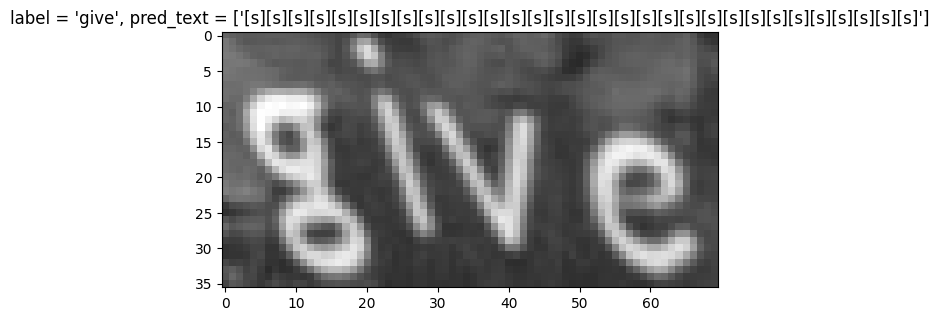

<Figure size 640x480 with 0 Axes>

label = 'stuff'


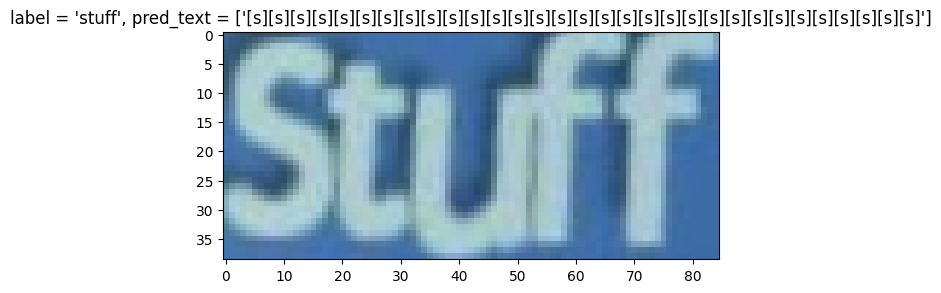

<Figure size 640x480 with 0 Axes>

label = 'would'


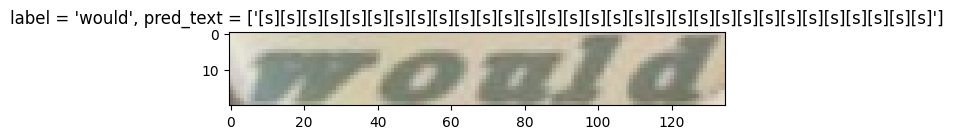

<Figure size 640x480 with 0 Axes>

label = 'you'


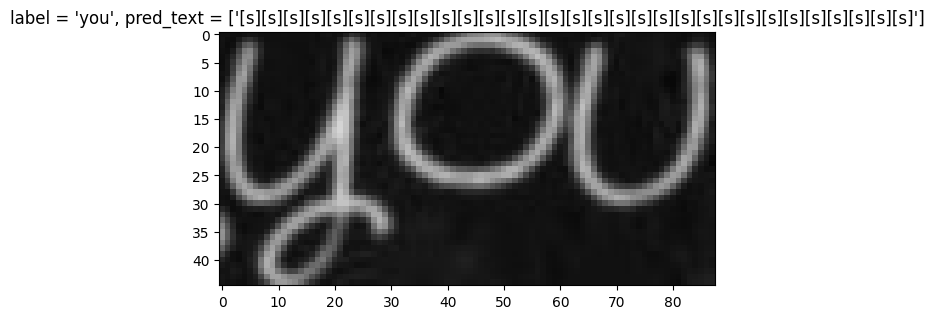

<Figure size 640x480 with 0 Axes>

label = 'the'


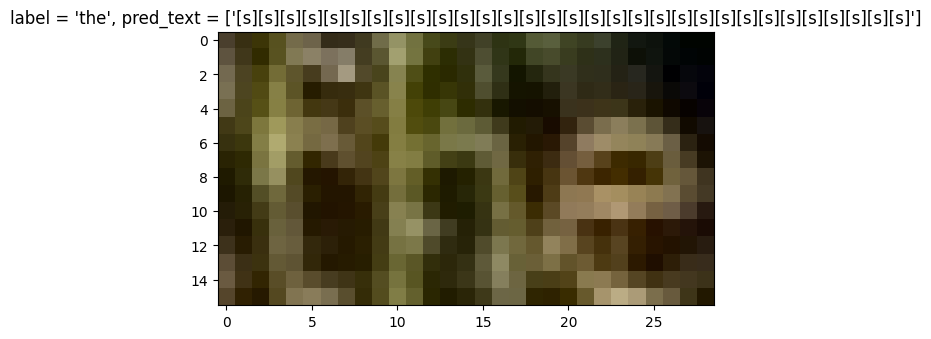

<Figure size 640x480 with 0 Axes>

In [71]:
with st_lmdb.begin(write=False) as txn:
    # for index in range(1, st_nSamples + 1):
    for index in range(5):
        index = random.randint(0, st_nSamples)
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8').lower()
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        print(f'{label = }')
        
        im_pil = Image.open(buf)

        torch_img, _ = pre_process([[im_pil.convert('L'), label]])
        text, _ = converter.encode([label], batch_max_length=opt.batch_max_length)
        text_inp = text[:, :-1]

        pred = model(torch_img, text_inp)
        pred_index = torch.argmax(pred, dim= 2)
        pred_len = torch.IntTensor([opt.batch_max_length] * 1)
        pred_text = converter.decode(pred_index.data, length=pred_len)
        cv2_img = pil_img_to_cv2(im_pil)
        plt.imshow(cv2_img)
        plt.title(f'{label = }, {pred_text = }')
        plt.figure()
        plt.show()
        

In [70]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [125]:
torch.argmax(pred, dim=-1).shape

torch.Size([1, 31])

In [126]:
dupe_pred = torch.softmax(pred, dim=-1).repeat(4, 1, 1)
dupe_pred.shape

torch.Size([4, 31, 38])

In [127]:
dupe_pred.view(-1, opt.num_class).shape

torch.Size([124, 38])

In [128]:
flattened_pred = dupe_pred.view(-1, dupe_pred.shape[-1])
flattened_pred.shape

torch.Size([124, 38])

In [129]:
sm_res = torch.softmax(pred, dim=-1)
sm_res = torch.flip(sm_res, [-2, -1])
sm_res.shape

torch.Size([1, 31, 38])

In [130]:
dupe_text = text.repeat(4, 1)
dupe_text.shape

torch.Size([4, 32])

In [131]:
flattened_text = dupe_text[:, 1:].contiguous().view(-1)
flattened_text.shape

torch.Size([124])

In [132]:
criterion(flattened_pred, flattened_text)

tensor(3.3600, grad_fn=<NllLossBackward0>)

In [123]:
#2.5878

torch.Size([1, 31, 38])

In [56]:
torch.argmax(pred, dim= 2).shape

torch.Size([1, 31])

In [41]:
type(converter)

utils.AttnLabelConverter

In [135]:
converter.character

['[GO]',
 '[s]',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']